# Projekt Code Induktive Erwärmung

In [1]:
from ngsolve import *
from netgen.geom2d import unit_square
from ngsolve.webgui import Draw
from netgen.csg import *
from netgen.geom2d import SplineGeometry
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.collections import LineCollection
from matplotlib.tri import Triangulation

### Konstanten

In [2]:
omega = 2*pi*50     # Frequenz 50 Hz
mu0 = 4*pi*1e-7     # Magnetische Feldkonstante

sigmaCu = 56e6      # S/m (Kupfer)
sigmaCore = 56e6    # S/m (Kupfer)

# Reihenfolge: air, copper, core
sigma = CoefficientFunction([0 , sigmaCu , sigmaCore ])
mur = CoefficientFunction([1 ,1 ,1])
nu = CoefficientFunction(1/mu0 * 1/mur ) # Permeabilität des Materials

ic = 10             # Strom in den Windungen (A)

# Mesh Generation
l_air = 0.1         # Grosse der dargestellten Luft um denn Versuchsaufbau
r_wire = 0.001      # Drahtdurchmesser in Metern
nx_wire = 10 #10        # Anzahl Kabel in X-Richtung
ny_wire = 3         # Anzahl Kabel in Y-Richtung
dxdy_wire = 0.5*r_wire

rA_core = 0.01      # Core Höhe
rI_core = 0.008
l_core = 0.08       # Core Länge
epsZero = 1e-8

### Mesh generation

In [3]:
geo = SplineGeometry()
geo.AddRectangle(p1=(-l_air/2,epsZero),
                 p2=(l_air/2,l_air/2),
                 bcs=["rotsym","outer_right","outer_top","outer_left"],
                 leftdomain=1,
                 rightdomain=0)
pts = []
for i in range(nx_wire):
    for j in range(ny_wire):
        pts.append([
            i*(2*r_wire+dxdy_wire), 
            rA_core+dxdy_wire+r_wire+j*(2*r_wire+dxdy_wire)
        ])
        geo.AddCircle(
            c=(i*(2*r_wire+dxdy_wire), 
               rA_core+dxdy_wire+r_wire+j*(2*r_wire+dxdy_wire)),
            r=r_wire, bc="inner",
            leftdomain=2,
            rightdomain=1)
pts = np.array(pts)
geo.AddRectangle(p1=(-l_core/2,rI_core),
                 p2=(l_core/2,rA_core),
                 bc="inner",
                 leftdomain=3,
                 rightdomain=1)
geo.SetMaterial (1, "air")
geo.SetMaterial (2, "copper")
geo.SetMaterial (3, "core")
geo.SetDomainMaxH(3,(rA_core-rI_core)/2)

mesh = Mesh(geo.GenerateMesh(maxh=0.0025))
print(mesh.GetBoundaries())

# Visualisierung
mat_mapping = {name: i+1 for i, name in enumerate(mesh.GetMaterials())}
cf = mesh.MaterialCF(mat_mapping)
Draw(cf, mesh, "material_colors")

('rotsym', 'outer_right', 'outer_top', 'outer_left', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'i

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## Aufgabe 1
1) Wie lautet die schwache Gleichung für die partielle Differentialgleichung (4)? Verifizieren Sie diese am Listing 2.
2) Berechnen Sie die Lösung und stellen Sie diese graphisch dar. Nutze Sie für die
Berechnung die Formel (5).
3) Berechnen Sie die induktive Wärmequelle q mit Hilfe von Formel (7).

#### 1) Schwache Gleichung der partiellen Differentialgleichung

Die Differentialgleichung lautet:
$$
\sigma j \omega A_\phi - \left( \frac{\partial}{\partial r} \left( \frac{\mu^{-1}}{r} \frac{\partial (r A_\phi)}{\partial r} \right) + \frac{\partial}{\partial z} \left( \mu^{-1} \frac{\partial A_\phi}{\partial z} \right) \right) = j_\phi
$$

Die schwache Formulierung ergibt sich, indem man beide Seiten mit einer Testfunktion  $v \in H^1$ (komplexwertiger FE-Raum) multipliziert und über das Gebiet  $\Omega$ integriert:

$$
\int_\Omega \left( \sigma j \omega A_\phi v - \frac{\partial}{\partial r} \left( \frac{\mu^{-1}}{r} \frac{\partial (r A_\phi)}{\partial r} \right) v - \frac{\partial}{\partial z} \left( \mu^{-1} \frac{\partial A_\phi}{\partial z} \right) v \right) \, d\Omega = \int_\Omega j_\phi v \, d\Omega
$$

Das Teilintegral mit zwei Ableitungen nach $r$ lässt sich u.A. durch partielle Integration vereinfachen.
$$ \frac{\partial (r A_\phi)}{\partial r}=A_\phi + r \frac{\partial (A_\phi)}{\partial r} \quad (Produktregel)$$
$$
\int_\Omega - \frac{\partial}{\partial r} \left( \frac{\mu^{-1}}{r} \frac{\partial (r A_\phi)}{\partial r} \right) v \, d\Omega = \underbrace{ \left[ - \frac{\mu^{-1}}{r} \frac{\partial (r A_\phi)}{\partial r} v \right]_{\partial\Omega}}_{=0} +
\int_\Omega \frac{\mu^{-1}}{r} \frac{\partial (r A_\phi)}{\partial r} \frac{\partial v}{\partial r} \, d\Omega =  \int_\Omega \mu^{-1} \left( \frac{A_\phi}{r} +  \frac{\partial A_\phi}{\partial r} \right)  \frac{\partial v}{\partial r} \, d\Omega 
$$

Die partielle Integration wird auch aufs Teilintegral mit zwei Ableitungen nach $z$ angewendet.
$$
\int_\Omega - \frac{\partial}{\partial z} \left( \mu^{-1} \frac{\partial A_\phi}{\partial z} \right) v \, d\Omega = \underbrace{ \left[ - \mu^{-1} \frac{\partial A_\phi}{\partial z} v \right]_{\partial\Omega}}_{=0} +
\int_\Omega \mu^{-1} \frac{\partial A_\phi}{\partial z} \frac{\partial v}{\partial z} \, d\Omega
$$

Die schwache Formulierung der Differentialgleichung lautet:

> $$ \underbrace{ \int_\Omega \sigma j \omega A_\phi v  + \mu^{-1} \left( \frac{A_\phi}{r} +  \frac{\partial A_\phi}{\partial r} \right)  \frac{\partial v}{\partial r} + \mu^{-1} \frac{\partial A_\phi}{\partial z} \frac{\partial v}{\partial z} \, d\Omega }_{\text{Bilinearform } a(A_\phi, v)} = \underbrace{ \int_\Omega j_\phi v \, d\Omega }_{\text{Linearfrom }  f(v)}, \quad \forall v \in H^1$$

wobei die Bilinearform  $a(A_\phi, v)$  durch die folgenden Terme definiert ist:

$$
a(A_\phi, v) = \int_\Omega \sigma j \omega A_\phi v \, d\Omega + \int_\Omega \mu^{-1} \left( \frac{A_\phi}{r} +  \frac{\partial A_\phi}{\partial r} \right)  \frac{\partial v}{\partial r} \, d\Omega  + \int_\Omega \mu^{-1} \frac{\partial A_\phi}{\partial z} \frac{\partial v}{\partial z} \, d\Omega
$$

#### 2) Numerische Lösung
##### Berechnung von $A_\phi$

In [4]:
### Listing 1 : Definition FE-Raum für Wirbelstromproblem
V = H1(mesh,order=3, complex=True, dirichlet='rotsym')
u,v = V.TnT()
gfu = GridFunction(V)

In [5]:
### Listing 2 : Definition Wirbelstrom Problem
# Wechsel in Zylinderkoordinaten (es wird nur ein Querschnitt dargestellt (phi = 0))
r = y
z = x
uz, ur = grad(u)
vz, vr = grad(v) 

# Schwache Gleichung als Bilinearform
a = BilinearForm(V)
a += (nu*(1/r*u+ur)*vr + nu*uz*vz)*dx # erster Bilinear term
a += 1j*omega*sigma*u*v*dx(definedon=mesh.Materials('copper|core')) # zweiter Bilinear term (sigma=0 in Luft)

Jimp = CoefficientFunction([0,ic/(r_wire**2*pi),0]) # Richtung und Stärke des Stroms al Impuls angegeben

f = LinearForm(V)
f += Jimp*v*dx(definedon=mesh.Materials('copper'))

a.Assemble()
f.Assemble()

gfu.vec.data = a.mat.Inverse(V.FreeDofs()) * f.vec

print("A_phi (Norm)")
Draw(Norm(gfu), mesh, "A_phi")

A_phi (Norm)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

##### Berechnung von $B_r$ und $B_z$
$$ B_r = - \frac{\partial A_\phi}{\partial z}$$

$$ B_z = \frac{1}{r} \frac{\partial (r A_\phi)}{\partial r} = \frac{A_\phi}{r} + \frac{\partial (A_\phi)}{\partial r}$$

In [6]:
# Create the coefficient functions
grad_gfu = grad(gfu)
B_r = -grad_gfu[0]  # Negative derivative with respect to z (x-coordinate)
#B_z = gfu / r + grad_gfu[1]  # Derivative with respect to r (y-coordinate)
rAphi = GridFunction(V)
rAphi.Set(r * gfu)
B_z = grad(rAphi)[1] / r
B_z = IfPos(r-epsZero, B_z, 0) # Handle potential division by zero at r=0 axis

# Create GridFunctions for visualization
B_r_gf = GridFunction(V)
B_z_gf = GridFunction(V)
# Project the expressions onto the finite element space
B_r_gf.Set(B_r)
B_z_gf.Set(B_z)

# Visualize Components
print("B_z (complex):")
Draw(B_z_gf, mesh, "B_z")
print("B_r (complex):")
Draw(B_r_gf, mesh, "B_r")

# Visualize as vector field
#B_field = CoefficientFunction(((B_z_gf.real), (B_r_gf.real)))  # For 2D visualization
t = Parameter(0) # oder t.Set()
B_field = CoefficientFunction((B_z_gf*exp(1j*omega*t), B_r_gf*exp(1j*omega*t)))  # For 2D visualization
print("B = Re([B_z, B_r]) (Vector):")
Draw(B_field.real, mesh, "B (Vector Field real part)", vectors=True)

print("B (Norm):")
Draw(Norm(B_field), mesh, "B (complex)")


B_z (complex):


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

B_r (complex):


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

B = Re([B_z, B_r]) (Vector):


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

B (Norm):


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## Zeitliche Visualisierung

[-0.002   0.0095]
[0.0245 0.0185]


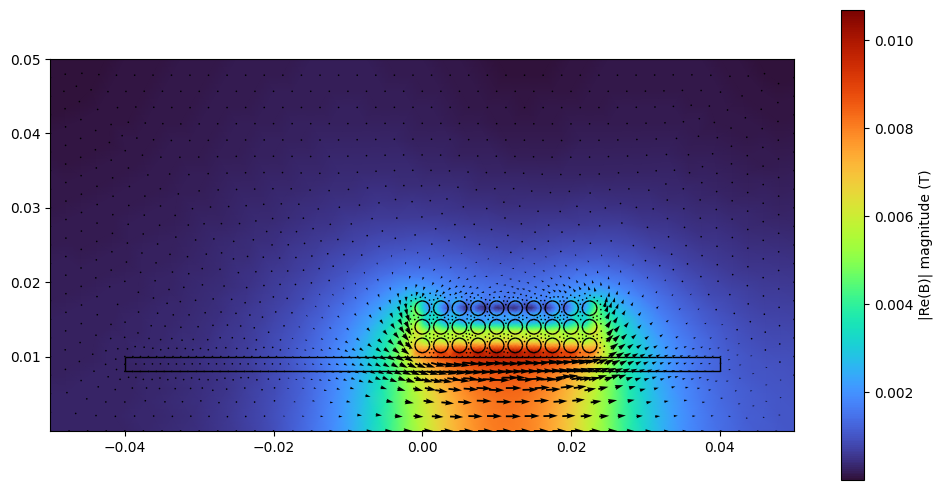

In [16]:
%matplotlib inline
#%matplotlib qt

# --- Mesh coordinates ---
mesh_coords = [(v.point[0], v.point[1]) for v in mesh.vertices]
x_vals = np.array([p[0] for p in mesh_coords])
y_vals = np.array([p[1] for p in mesh_coords])

# --- Triangulation ---
triangles = []
for el in mesh.Elements(VOL):
    if len(el.vertices) == 3:
        triangles.append([v.nr for v in el.vertices])
triang = Triangulation(x_vals, y_vals, np.array(triangles))

# --- Mask vertices in copper regions ---
is_in_copper = np.zeros(len(mesh.vertices), dtype=bool)
for el in mesh.Elements(VOL):
    if el.mat == "copper":
        for v in el.vertices:
            is_in_copper[v.nr] = True
# --- Additional mask: quiver hide box around wires ---
# Compute bounding box of the copper wires
x_min, y_min = pts.min(axis=0) - 2*r_wire
print(pts.min(axis=0)-2*r_wire)
x_max, y_max = pts.max(axis=0) + 2*r_wire
print(pts.max(axis=0)+2*r_wire)
is_in_quiver_mask = np.zeros(len(mesh.vertices), dtype=bool)

for i, (x, y) in enumerate(mesh_coords):
    # Already exclude copper region
    if is_in_copper[i]:
        is_in_quiver_mask[i] = True
    # Also exclude if inside bounding box of wire grid
    elif x_min <= x <= x_max and y_min <= y <= y_max:
        is_in_quiver_mask[i] = True

# --- Prepare B-field storage ---
Bx_all, By_all, Bmag_all = [], [], []
T = 1 / (omega / (2 * pi))
times = np.linspace(0, T, 100)

# --- Grid function ---
V = VectorH1(mesh, order=3)
B_gf = GridFunction(V)

# --- Evaluate B field over time ---
for t_val in times:
    t.Set(t_val)
    B_gf.Set(B_field.real)

    Bx_frame, By_frame, Bmag_frame = [], [], []
    for i, (x, y) in enumerate(mesh_coords):
        try:
            val = B_gf(x, y)
            Bx, By = float(val[0]), float(val[1])
            if is_in_quiver_mask[i]:
                Bx_frame.append(0)
                By_frame.append(0)
            else:
                Bx_frame.append(Bx)
                By_frame.append(By)
            Bmag_frame.append(np.sqrt(Bx**2 + By**2))
        except:
            Bx_frame.append(0)
            By_frame.append(0)
            Bmag_frame.append(0)

    Bx_all.append(Bx_frame)
    By_all.append(By_frame)
    Bmag_all.append(Bmag_frame)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_aspect('equal')
ax.set_xlim(min(x_vals), max(x_vals))
ax.set_ylim(min(y_vals), max(y_vals))

# --- Draw material boundaries ---
edges = {}
for el in mesh.Elements(VOL):
    material = el.mat
    for i in range(len(el.vertices)):
        v1 = el.vertices[i]
        v2 = el.vertices[(i+1) % len(el.vertices)]
        edge = tuple(sorted([v1.nr, v2.nr]))
        if edge not in edges:
            edges[edge] = []
        edges[edge].append(material)

boundary_lines = []
for edge, materials in edges.items():
    if len(set(materials)) > 1:
        v1, v2 = edge
        p1, p2 = mesh_coords[v1], mesh_coords[v2]
        boundary_lines.append([p1, p2])

line_collection = LineCollection(boundary_lines, linewidths=1, colors='black')
ax.add_collection(line_collection)

# --- Background field magnitude ---
cmap = plt.cm.turbo
vmin = np.min(Bmag_all)
vmax = np.max(Bmag_all)
bg = ax.tripcolor(triang, np.array(Bmag_all[0]), shading='gouraud', cmap=cmap, vmin=vmin, vmax=vmax)
cb = fig.colorbar(bg, ax=ax, label='|Re(B)| magnitude (T)')

# --- Initial quiver plot (masked)
Bx0 = np.ma.masked_array(Bx_all[0], mask=is_in_copper)
By0 = np.ma.masked_array(By_all[0], mask=is_in_copper)
quiver = ax.quiver(x_vals, y_vals, Bx0, By0, color='black', scale=0.4)

# --- Animation update ---
def update_quiver(frame):
    Bx = np.ma.masked_array(Bx_all[frame], mask=is_in_copper)
    By = np.ma.masked_array(By_all[frame], mask=is_in_copper)
    quiver.set_UVC(Bx, By)
    bg.set_array(np.asarray(Bmag_all[frame]))
    ax.set_title(f"B-field (Re(B) shown, no quiver in copper)\nTime: {times[frame]*1000:.1f} ms")
    return quiver, bg

ani = animation.FuncAnimation(fig, update_quiver, frames=len(times), interval=50)
plt.tight_layout()
plt.show()

In [8]:
#writer_gif = PillowWriter(fps=20)
#ani.save("animation.gif", writer=writer_gif)

#### 2 Induktive Wärmequelle
Die Formel (7) für die induktive Wärmequelle lautet:

$$
q = \frac{1}{2} | \mathbf{J} \cdot \mathbf{E} | = \frac{\sigma}{2} |\mathbf{E}|^2 
$$

Dabei gilt:

$\sigma$ ist die elektrische Leitfähigkeit (z. B. $56 \times 10^6 \, \text{S/m}$ für Kupfer).

$\mathbf{E}$ ist das elektrische Feld.

$$
\mathbf{J}_{\text{int}} = \sigma \mathbf{E} \quad \text{(Ohmsches Gesetz für Leiter)}
$$

Die Größe $q$ beschreibt die Wärmeerzeugung pro Volumen $(\text{W/m}^3)$ aufgrund des induktiven Joule-Effekts.

Im rotationssymmetrischen Fall ist das elektrische Feld gegeben durch:

$$
\mathbf{E} = -j \omega A_\phi \quad \text{(laut Formel (6))}
$$

Nun wird eine Formel für $q$ abhängig von $\sigma$, $\omega$ und $A_\phi$ hergeleitet.

$$ \begin{align}
q &= \frac{1}{2} | \mathbf{J} \cdot \mathbf{E} | = \frac{1}{2} | (\mathbf{J}_{\text{int}} + \mathbf{J}_{\text{ext}})\cdot \mathbf{E} | \\
&= \frac{1}{2} | ( \sigma \mathbf{E} + \mathbf{J}_{\text{ext}})\cdot \mathbf{E} | \\
\end{align}$$


In [9]:
### Listing 3 : Berechnung der induktiven Wärmequelle
Ez = -1j*omega*gfu  # Elektrische Feldstärke
Jz = sigma*Ez       # Elektrischer Strom
Jtot = Jz + Jimp
Qe = 1/2*Norm(InnerProduct(Jtot,Ez)) # Induktive Wärmequelle

Draw(Qe, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [10]:
V2 = L2(mesh, order=4)
gf = GridFunction(V2)
gf.Set(Qe)
Draw(gf, mesh)

# Now save as above
np.save("qe_export.npy", gf.vec.FV().NumPy())
gf.Save("qe_gf.gf")
mesh.ngmesh.Save("my_mesh.vol")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…